# PipeTorch Train module

The train module is build around a general purpose Trainer for PyTorch, to quickly train, tune and validate PyTorch models. Much of the training is readily available in PyTorch, we have mostly made it a bit easier to use. Because of the modular design, you can use this trainer with any PyTorch DataLoader and model.

We we cover training in the following topics:
- [Quick example](#Quick-example)
- [Trainer](#Trainer): how to instantiate and configure the trainer
- [train()](#train()): how to train a model
- [Commit](#Commit): how to commit and checkout to models
- [Model management](#Model-management): how to load and save models
- [lr_find()](#lr_find()): to tune the learning rate
- [Hyperparameter tuning](#Hyperparameter-tuning): to assist in tuning multiple hyperparameters using random search

# Quick example

In this example, we will train a model to predict mpg for the autompg dataset. Look at [Trainer configuration](#Trainer) and [train](#train()) for more on the possibilities of training. 

In [1]:
from pipetorch.data import DFrame
from pipetorch.model import Perceptron
from pipetorch.train import *
from sklearn.metrics import r2_score
from torch import nn

using gpu 1


In [2]:
df = DFrame.read_from_kaggle('uciml/autompg-dataset')
df = df.drop(columns=['car name', 'horsepower']).columny('mpg').split(0.2).scale()
db = df.to_databunch(batch_size=32)

In [3]:
model = Perceptron(6, 100, 1)   # 6 features, 1 target, hidden layer 100

In [4]:
t = Trainer(model, nn.MSELoss(), db, metrics=r2_score)

In [5]:
t.train(100, (3e-4), silent=True)

You can visually diagnose training through `t.learning_curve()`, `t.validation_curve(y=metric)` or a combined plot of loss and all logged metrics through `t.curves()`

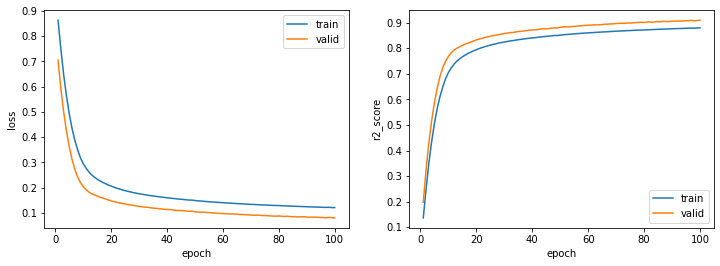

In [6]:
t.curves()

# Trainer

A general purpose trainer for PyTorch.
```
Args:
    model: nn.Module
        a PyTorch Module that will be trained

    loss: callable
        a PyTorch or custom loss function. Note that the loss functions in PyTorch have to be initialized, e.g. nn.BCELoss() and not nn.BCELoss

    *data: databunch or a list of iterables like DataLoaders
        this will take either an object that has a .train_dl, .valid_dl, and optionally .test_dl property,
        like  PipeTorch Databunch (but it does not have to be a Databunch). Alternatively, you can 
        pass a list of at least two iterables (train and valid) like PyTorch DataLoaders. 

    metrics: callable or [ callable ] ([])
        One or more functions that can be called with (y_true, y_pred) to compute an evaluation metric. 
        These metric function will be used during training, for both the train and valid sets at the 
        end of each cycle and logged for validation. Typically, the callable is a function from 
        SKLearn.metrics like mean_squared_error or recall_score. The loss is always logged.

    optimizer: PyTorch Optimizer (AdamW)
        A PyTorch or custom optimizer class that is used during training to update the model parameters.
        You should pass the class and not an optimizer instance. By default, the AdamW optimizer is assumed
        and better supported than other optimizers are.

    optimizer_params: dict (None)
        The parameters that are passed (along with the model parameters) to initialize an optimizer. 
        When a None value is set, the key is removed, so that the default value is used instead.

    scheduler: func or class (None)
        A function or class that returns an intialized scheduler that will be used to change 
        the learning rate and optimizer behavior. Omitting this will allow you to use the lr parameter
        on the train() function to invoke a constant, decaying and cyclic scheduler, that will probably
        suit most needs. Alternatively, if you set this, the function that is called has to accept
        (optimizer, lr, **scheduler_params) as parameters.

    scheduler_params: dict (None)
        additional parameters that are passed when initializing the scheduler

    weight_decay: float (None)
        Apply weight_decay regularization with the AdamW optimizer

    momentum: float (None)
        Apply momentum with the AdamW optimizer

    random_state: int (None)
        used to set a random state for reproducible results

    gpu: bool, int or torch.device (False)
        The device to train on:
            False or -1: cpu
            True: cuda:0, this is probably what you want to train on gpu
            int: cuda:gpu
        Setting the device will automatically move the model and data to the given device. Note that 
        the model is not automatically transfered back to cpu afterwards.

    evaluator: PipeTorch evaluator (None)
        An evaluator that was created by a different trainer or DataFrame, to combine the results of 
        different training sessions.

    post_forward: func (None)
        For some projects, the loss function requires a different output than
        the metrics that are being used. 
        
        Example 1: For nn.BCELoss() the target value
        must be a likelihood, while accuracy_score requires a class label. 
        The model returns a likelihood with an nn.Sigmoid() on the ouput layer, 
        but the metrics can only be computed if the likelihood is converted into 
        a predicted label (e.g. torch.round() ). 
        
        Example 2: nn.CrossEntropyLoss() requires a distribution over the possible labels
        while multi-class evaluation matrics require the predicted class. This is commonly
        computed with torch.argmax(y, dim=1).
        
        To allow for this behavior, the trainer can use a post_forward fuction inbetween
        loss and metrics. It will attempt to use a post_forward in the following order: 
        - a function passed here
        - a post_forward method that is added to the model
        - infer a post_forward based on the loss function. 
        
        For inferring a post_forward based on
        the loss function, there is a dictionary in train.POST_FORWARD that covers the 
        most commonly used loss functions.

        If no post_forward is found, and the loss function is unknown, then None is used
        and a warning is printed. Pass post_forward=False to suppress this warning.
        
    debug: bool (False)
        Stores X, y and y_pred in properties so that they can be inspected when an error is thrown.
        You can use t.debug() to reveal the last values for X, y, model(X) and post_forward(model(X)).
```

The quick example shows how this can be used with a Databunch. In this alternative, we pass separate dataloaders to the Trainer, turn gpu=True to train the model on the gpu, and lower the default weight_decay (regularization).

In [7]:
from pipetorch.data import DFrame
from pipetorch.model import Perceptron
from pipetorch.train import *
from sklearn.metrics import r2_score
from torch import nn

In [8]:
df = DFrame.read_from_kaggle('uciml/autompg-dataset')
df = df.drop(columns=['car name', 'horsepower']).columny('mpg').split(0.2).scale()
train_dl = df.train.to_dataloader(batch_size=32)
valid_dl = df.valid.to_dataloader(batch_size=len(df.valid))

In [9]:
model = Perceptron(6, 100, 1)   # 6 features, 1 target, hidden layer 100

In [10]:
t = Trainer(model, nn.MSELoss(), train_dl, valid_dl, metrics=r2_score, gpu=True, weight_decay=1e-4)

In [11]:
t.train(100, 1e-4, silent=True, log={'custom':'my value'})

### results

The values for the loss function and metrics will be stored atthe end of every cycle in a PipeTorch Evaluator, that uses a DataFrame to log all results. If you want to access these for an alternative way to diagnose training, you can access the raw data through `r.evaluator.results`. You can use the `log` parameter on [train()](train()) to record additional information.

In [12]:
t.evaluator

       custom  epoch    metric  phase     value
0    my value    1.0  r2_score  valid  0.018135
1    my value    1.0      loss  valid  0.909932
2    my value    1.0  r2_score  train  0.064749
3    my value    1.0      loss  train  0.935251
4    my value    2.0  r2_score  valid  0.066624
..        ...    ...       ...    ...       ...
395  my value   99.0      loss  train  0.171425
396  my value  100.0  r2_score  valid  0.853293
397  my value  100.0      loss  valid  0.135959
398  my value  100.0  r2_score  train  0.829248
399  my value  100.0      loss  train  0.170752

[400 rows x 5 columns]

# train()

Train the model for the given number of epochs or until a targetloss or earlystop criterium is reached. Loss and metrics are logged at the end of each cycle during training in an evaluator. If a model was already (partially) trained, training will continue where it was left off.
```
Args:
    epochs: int
        the number of epochs to train the model

    lr: float, (float, float), or [float, float] (None)
        float: use a fixed learning rate
        (upper, lower): switch the scheduler to OneCycleLR and use a cyclic annealing learning rate
            between an upper and lower bound.
        [upper, lower]: switch the scheduler to Linear Decay and use a linearly decaying learning rate
            between an upper and lower bound.
        None: use the last learning rate or the default in AdamW

    cycle: int (None)
        Configures after how many epochs there are in a cycle the loss and metrics are logged and 
        reported at the end of every cycle. This is remembered for consecutive calls to train.

    silent: bool (False)
        Whether to report progress. Note that even when silent=True
        the metrics are still logged at the end of every cycle.

    log: dict ({})
        these values are logged along with the loss and metric scores at the end of each cycle. This makes it
        easier to combine several runs into one evaluator, and create an overview (plot) to compare them.

    save: str (None)
        If not None, saves (commits) the model at the end of each cycle
        under the name 'save'-epochnr

    optimizer: PyTorch Optimizer (None)
        If not None, changes the optimizer class to use.

    optimizer_params: dict (None)
        If not None, changes the parameters to configure the optimizer.

    scheduler: None, custom scheduler class
        used to adapt the learning rate. Set OneCycleLR or Linear Decay through the learning rate. 
        Otherwise, provide a custom class/function to initialize a scheduler by accepting
        (optimizer, learning_rate, scheduler_cycle)

    scheduler_params: dict (None)
        additional parameters that are passed when initializing the scheduler

    weight_decay: float
        Apply weight_decay regularization with the AdamW optimizer

    momentum: float
        Apply momentum with the AdamW optimizer

    targetloss: float (None)
        terminates training when the validation loss drops below the targetloss.

    earlystop: int (False)
        terminates training when the validation loss has not improved for the last
        earlystop cycles.

    save_lowest: bool (False)
        when the validation loss is lower than seen before, the model is saved/committed as 'lowest' 
        and can be checked out by calling lowest() on the trainer.

    log: {}
        At the end of every cycle, the loss and metrics over the train, valid
        and optionally test sets are computed and stored in a result set. The
        values passed in log are stored along with this metrics. Typically, this
        is used with a single trainer that is reused for several 'trials' 
        to analyze how the results changes. Several functions on the resultset
        allow to 'select' results based on these settings, are generate plots
        with these settings as 'series'.

    test: bool (False)
        run the test set every cycle (used for n-fold cross validation)
```

In [13]:
from pipetorch.data import DFrame
from pipetorch.model import Perceptron
from pipetorch.train import *
from sklearn.metrics import r2_score
from torch import nn

In [14]:
df = DFrame.read_from_kaggle('uciml/autompg-dataset')
df = df.drop(columns=['car name', 'horsepower']).columny('mpg').split(0.2).scale()
db = df.to_databunch(batch_size=32)

In [15]:
model = Perceptron(6, 100, 1)   # 6 features, 1 target, hidden layer 100

In [16]:
t = Trainer(model, nn.MSELoss(), db, metrics=r2_score)

Without `silent=True`, the train() method will report losses and metrics over the validation set at the end of every cycle. It will also use a progress bar to give you an indication how long training will take.

In [17]:
t.train(20, 1e-4, cycle=10)

Total:   0%|          | 0/6560 [00:00<?, ?it/s]

10 0.13s trainloss=0.68887 validloss=0.56438 r2_score=0.32453 
20 0.12s trainloss=0.47187 validloss=0.39192 r2_score=0.53094 


A subsequent call to train will continue where you have left off, allowing to change the learning hyperparameters.

In [18]:
t.train(20, 1e-4, cycle=10)

Total:   0%|          | 0/6560 [00:00<?, ?it/s]

30 0.12s trainloss=0.33397 validloss=0.29175 r2_score=0.65082 
40 0.12s trainloss=0.27188 validloss=0.24682 r2_score=0.70460 


# Commit

The Trainer provides a mechanism to commit, checkout and revert to different versions of the model. For example, for multi-stage learning a model that may overfit, the process can be automated by training in the first stage, reverting back to the model with the lowest validation loss, and then proceeding with the next stage. There are several options:
- t.train(..., save_lowest=True): commits a model if the validation loss is lowest than ever seen. You can retrieve the 'best' model using `t.lowest()`
- t.train(..., save='mymodel'): commits versions of the model after every cycle under the name 'mymodel-{epoch}'

When working with committed models, you can use the following functions to work with them:
- t.commit(label): commits the current model under this label
- t.list_commits(): lists the names of all committed models
- t.revert(label): returns the model to that committed state and removes the commit point
- t.checkout(label): returns the model to that committed state and keeps the commit point
- t.purge(label): returns the model to that committed state and removes all other commit points

In [19]:
from pipetorch.data import DFrame
from pipetorch.model import Perceptron
from pipetorch.train import *
from sklearn.metrics import r2_score
from torch import nn

In [20]:
df = DFrame.read_from_kaggle('uciml/autompg-dataset')
df = df.drop(columns=['car name', 'horsepower']).columny('mpg').split(0.2).scale()
db = df.to_databunch(batch_size=32)

In [21]:
model = Perceptron(6, 100, 1)   # 6 features, 1 target, hidden layer 100

In [22]:
t = Trainer(model, nn.MSELoss(), db, metrics=r2_score)

We will use a learning rate that is to high so that it is likely that the learning curve will oscillate.

In [23]:
t.train(100, 1e-2, cycle=10, save_lowest=True)

Total:   0%|          | 0/32800 [00:00<?, ?it/s]

 10 0.13s trainloss=0.11634 validloss=0.09712 r2_score=0.91131 
 20 0.12s trainloss=0.10446 validloss=0.11478 r2_score=0.89519 
 30 0.12s trainloss=0.09807 validloss=0.09653 r2_score=0.91185 
 40 0.12s trainloss=0.08955 validloss=0.07551 r2_score=0.93105 
 50 0.12s trainloss=0.08146 validloss=0.08662 r2_score=0.92090 
 60 0.12s trainloss=0.08999 validloss=0.09134 r2_score=0.91659 
 70 0.12s trainloss=0.08482 validloss=0.07986 r2_score=0.92707 
 80 0.12s trainloss=0.08690 validloss=0.07284 r2_score=0.93349 
 90 0.12s trainloss=0.07247 validloss=0.08108 r2_score=0.92596 
100 0.12s trainloss=0.08100 validloss=0.08568 r2_score=0.92176 


Checkout to the lowest version and look at the valdation loss.

In [24]:
t.lowest()

In [25]:
t.validate_loss()

0.07283725589513779

# Model management

The Trainer has built-in function to load, save and reset the model:
- `t.save(folder, filename, extension)`: saves the current model. By default, currentfolder/classname.pyt-{PyTorch version} will be used.
- `t.load(folder, filename, extension)`: loads the saved model.
- `t.reset_model()`: reinitializes all weights to random.
- `t.to(device)`: changes the configuration to a different device, which will take effect when calling `t.model` or any function that uses the model (like `train()`)
  - `False`: cpu
  - `True`: cuda:0
  - `int`: cuda:{device}

# lr_find()

This method helps optimizing the learning rate finder of the current model on the current dataset (as proposed by Leslie Smith and implemented in FastAI). This function commits the model, then iteratively trains over mini-batches while slowly increasing the learning rate.

The result is a plot of the validation loss over the learning rate. The idea is that the graph contains information on a stable setting of the learning rate and it is recommended to set the learning rate at the lowest learning rate that accelerates improvement of the loss. This does not always work, and often after some training, if learning is not stable, the learning rate still needs to be adjusted. 
```
Args:
    lr: [small float, big float] ([1e-6, 10])
        Interval of learning rates to inspect
        
    steps: int (40)
        Number of (exponential) steps to divide the learning rate interval in
        
    smooth: float (0.05)
        Smoothing parameter, to generate a more readable graph
        
    cache_valid: bool (True)
        Whether to keep the validation set if possible in memory. Switch off if there is insufficient memory
        
    interactive: bool (False)
        When True, switches your notebook to `matplotlib notebook` mode to update the graph during 
        the analysis. Afterwards, the notebook is switched to `matplotlib inline` mode to turn 
        off interactive plots which is probably better for other plots (no widgets around the plots).
```

In [12]:
from pipetorch.data import DFrame
from pipetorch.model import Perceptron
from pipetorch.train import *
from sklearn.metrics import r2_score
from torch import nn

In [27]:
df = DFrame.read_from_kaggle('uciml/autompg-dataset')
df = df.drop(columns=['car name', 'horsepower']).columny('mpg').split(0.2).scale()
db = df.to_databunch(batch_size=32)

In [28]:
model = Perceptron(6, 100, 1)   # 6 features, 1 target, hidden layer 100

In [29]:
t = Trainer(model, nn.MSELoss(), db, metrics=r2_score)

So on this example, a learning rate of 1e-2 is clearly too high, but a setting of 3e-3 may already be too close to the 'danger zone' so that the model does not fully converge. Therefore a setting of 1e-3 may be optimal, since this is where the loss accelerates.

  0%|          | 0/40 [00:00<?, ?it/s]

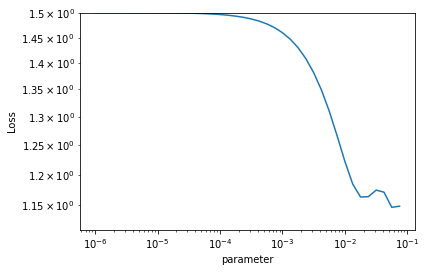

In [30]:
t.lr_find([1e-6, 1e-1], 40)

# Hyperparameter tuning

Hyperparameters are usually not learned directly from training, but by trying out different settings, fully training a model each time and comparing the results. PipeTorch embeds the Optuna library to assist in tuning. You will need to provide a function that performs a 'trail' in which a model is optimally trained and the results are returned. Within this trial function, you will use the Optuna.Trial object that is passed to sample your hyperparameters from a random distribution.

When you call `optimize`, `cross_validate` or `study` from the Trainer, you will receive a PipeTorch extension to an Optuna Study, that will call a trial with (trainer, trial) instead of just (trial). This allows you to easily setup your trials with a consistent training process, and record all trials in a single resultset for comparison. Typically, program your `perform_trial` function in the following way:
- Sample hyperparameters: use the trial to sample values for the hyperparameters you wish to tune, as described in the Optuna library.
- Model: either reset the model (`trainer.reset_model()`) or assign a new model with a different configuration to the trainer (`trainer.model = ...`). Both will reset the epoch counter on the trainer to start recording a new trial.
- Train: call [train()](#train()) as usual, allow for enough epochs to optimize over less efficient settings. **Important:** in `train()`, use `log={}` to add a dictionary of values that distinguish the trials. Typically, these are the settings that you tune. If you do not add a log to distinguish trails, you will probably get an error, but otherwise the trainer may not return the correct optimum. You can also use a more sophisticated training routines, consisting of several calls to `train()`, for example adjusting the learning rate.
- Optimum: finish with [trainer.optimum()](#Trainer.optimum()). This will return a tuple with the configured metrics of the epoch with the lowest validation loss. The `log={}` values are used to determine what tha recordings are from the current trial. These results are used by Optuna to find the sweet spot for every hyperparameter. 

Then for the Trainer, consider the following steps:
- Metrics: [configure your trainer](#Trainer) with the metrics you wish to optimize for.

In [1]:
from pipetorch.data import DFrame
from pipetorch.model import Perceptron
from pipetorch.train import *
from sklearn.metrics import r2_score
from torch import nn

using gpu 1


In [2]:
df = DFrame.read_from_kaggle('uciml/autompg-dataset')
df = df.drop(columns=['car name', 'horsepower']).columny('mpg').split(0.2).scale()
db = df.to_databunch(batch_size=32)

In [7]:
t = Trainer(None, nn.MSELoss(), db, metrics=r2_score)

In [8]:
def trial(trainer, trial):
    hidden = trial.suggest_int('hidden', 1, 100)
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    trainer.model = Perceptron(6, hidden, 1)
    t.train(200, lr=lr, weight_decay=0.01, earlystop=10, silent=True, log={'lr':lr, 'hidden':hidden})
    return t.optimum()

In [10]:
study = t.optimize(trial, n_trials=20)

[I 2022-06-10 08:50:35,334] A new study created in memory with name: no-name-48f1d988-6761-4977-9beb-8294b3da547a
[I 2022-06-10 08:50:40,546] Trial 0 finished with values: [0.09150464087724686, 0.9156586490161833] and parameters: {'hidden': 56, 'lr': 0.002610894784582419}. 
[I 2022-06-10 08:50:45,635] Trial 1 finished with values: [0.6728812456130981, 0.3797942085065116] and parameters: {'hidden': 14, 'lr': 2.9965715958368795e-05}. 
[I 2022-06-10 08:50:50,907] Trial 2 finished with values: [0.2590765357017517, 0.7612048437664654] and parameters: {'hidden': 92, 'lr': 2.1717681543404855e-05}. 
[I 2022-06-10 08:50:56,150] Trial 3 finished with values: [0.09520615637302399, 0.9122469036549361] and parameters: {'hidden': 56, 'lr': 0.009790773708480324}. 
[I 2022-06-10 08:51:01,408] Trial 4 finished with values: [0.09007344394922256, 0.9169778123657625] and parameters: {'hidden': 64, 'lr': 0.010054678410232137}. 
[I 2022-06-10 08:51:06,666] Trial 5 finished with values: [0.17039711773395538,

The resulting plot can be a bit of a puzzle to figure out. Just looking at the loss, the high values indicate bad results. If for a certain hyperparameter a whole region (usually on the left or right hand side of the plot) has bad results, that is an indication the underperformance could have been caused by setting the hyperparameter in that region. However, if another hyperparameter is already causing a bad result, you should disregard that in the analysis of the other hyperparameters. In the future, we may provide a more clever mechanism for this analysis.

In this example, you should see that learning rates below $10e-4$ are underperforming, but also that learning rates close to $1e-1$ become too big. In the analysis of the hidden layer size, you should ignore the trails that are underperforming due to a wrong learning rate. Then it appears there is a trend that higher hidden size values perform better. We should rerun with even higher values to find the optimum.

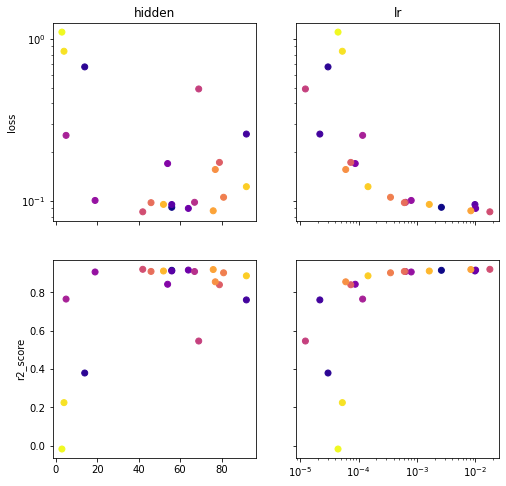

In [11]:
study.plot_hyperparameters()

You can also view the flat results in a DataFrame.

In [12]:
study.results()

,trial,parameter,parametersetting,target,targetvalue
0,0,hidden,56.000000,loss,0.091505
1,0,hidden,56.000000,r2_score,0.915659
2,0,lr,0.002611,loss,0.091505
3,0,lr,0.002611,r2_score,0.915659
4,1,hidden,14.000000,loss,0.672881
...,...,...,...,...,...
75,18,lr,0.000053,r2_score,0.225300
76,19,hidden,3.000000,loss,1.103152
77,19,hidden,3.000000,r2_score,-0.016794
78,19,lr,0.000044,loss,1.103152


# Trainer.optimum()

```
Finds the cycle at which optimal results where obtained over the validation set, on the given optimization
metric. 

Args:
    *target: str or callable ('loss')
        names or metric functions that are used to decide what training cycle the model was most optimal

    direction: str or [ str ] (None)
        for every target: 'minimize' or 'maximize' to find the highest or lowest value on the given target
        If None, 'minimize' is used when optimize is 'loss', otherwise 'maximize' is used

    directions: [ str ] (None)
        same as direction, but now a list of 'minimize' or 'maximize' for multipe targets.

    select: {} (None)
        When None, the log={} values from the last call to train() are used. Otherwise, select
        is a dictionary with values that distinguish the results from the current trial 
        to the previous trails, which is needed to find the single best epoch of the current trail
        to return the metrics for that epoch.

Returns:
    [ target ]
    A list of target values 
```

In [1]:
from pipetorch.data import DFrame
from pipetorch.model import Perceptron
from pipetorch.train import *
from sklearn.metrics import r2_score
from torch import nn

using gpu 1


In [2]:
df = DFrame.read_from_kaggle('uciml/autompg-dataset')
df = df.drop(columns=['car name', 'horsepower']).columny('mpg').split(0.2).scale()
db = df.to_databunch(batch_size=32)

In [3]:
t = Trainer(Perceptron(6, 100, 1), nn.MSELoss(), db, metrics=r2_score)

In [4]:
t.train(10, lr=1e-3, log={'hidden':100})

Total:   0%|          | 0/4000 [00:00<?, ?it/s]

 1 0.09s trainloss=0.65363 validloss=0.52525 r2_score=0.45151 
 2 0.03s trainloss=0.40593 validloss=0.35695 r2_score=0.62726 
 3 0.03s trainloss=0.29211 validloss=0.28940 r2_score=0.69779 
 4 0.02s trainloss=0.24881 validloss=0.26373 r2_score=0.72460 
 5 0.02s trainloss=0.23068 validloss=0.24384 r2_score=0.74537 
 6 0.03s trainloss=0.21536 validloss=0.22640 r2_score=0.76358 
 7 0.02s trainloss=0.20176 validloss=0.21037 r2_score=0.78032 
 8 0.02s trainloss=0.19092 validloss=0.19746 r2_score=0.79380 
 9 0.02s trainloss=0.18229 validloss=0.18389 r2_score=0.80798 
10 0.03s trainloss=0.17384 validloss=0.17340 r2_score=0.81893 


In [5]:
t.model = Perceptron(6, 200, 1)

In [6]:
t.train(10, lr=1e-3, log={'hidden':200})

Total:   0%|          | 0/4000 [00:00<?, ?it/s]

 1 0.03s trainloss=0.77873 validloss=0.52921 r2_score=0.44738 
 2 0.03s trainloss=0.34269 validloss=0.29897 r2_score=0.68781 
 3 0.03s trainloss=0.24859 validloss=0.25412 r2_score=0.73464 
 4 0.03s trainloss=0.22734 validloss=0.21513 r2_score=0.77535 
 5 0.02s trainloss=0.19699 validloss=0.19056 r2_score=0.80101 
 6 0.02s trainloss=0.18450 validloss=0.17366 r2_score=0.81866 
 7 0.02s trainloss=0.17464 validloss=0.16044 r2_score=0.83246 
 8 0.03s trainloss=0.16926 validloss=0.14931 r2_score=0.84408 
 9 0.02s trainloss=0.15954 validloss=0.14130 r2_score=0.85245 
10 0.03s trainloss=0.15667 validloss=0.13484 r2_score=0.85920 


In [7]:
t.optimum()

[0.1348363757133484, 0.859198487301008]

In [8]:
t.optimum(r2_score)

[0.859198487301008]

In [11]:
t.optimum(hidden=100)

[0.17339988052845, 0.8189289600394625]